# GPLearn for Image Synthesis

## Imports

In [1]:
from gplearn.genetic import SymbolicRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import graphviz
from sklearn.metrics import make_scorer
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from gplearn.fitness import make_fitness
import os
import pickle
import sys
from utils.comparison import *
import contextlib

In [2]:
START_GENERATIONS = 30
POP_SIZE = 50
FINETUNE_GENERATIONS = 5
ADDITIONAL_GENERATIONS = 5

## Data

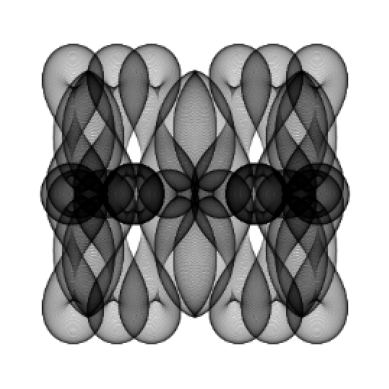

In [3]:
k = np.arange(1, 7001).reshape(-1, 1)

a_true = np.cos(2 * np.pi * k.flatten() / 7000)
b_true = np.sin(18 * np.pi * k.flatten() / 7000) ** 3
r_true = (1/4) * (np.cos(42 * np.pi * k.flatten() / 7000)) ** 2
target_image = generate_image(k.flatten(), a_true, b_true, r_true)
target_processed = preprocess(target_image)

plt.imshow(target_processed, cmap="gray")
plt.axis('off')
plt.show()

## Experiments

In [4]:
@contextlib.contextmanager
def suppress_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stderr = os.dup(2)
        os.dup2(devnull.fileno(), 2)
        try:
            yield
        finally:
            os.dup2(old_stderr, 2)
            os.close(old_stderr)

In [5]:
np.seterr(divide='ignore', invalid='ignore')

def protected_div(x1, x2):
    return np.where(np.abs(x2) > 1e-6, x1 / x2, 1.0)

def make_const_fn(value):
    def const_fn(x=None):
        return np.full(x.shape[0], value)
    return const_fn

def protected_div(x1, x2):
    return np.where(np.abs(x2) > 1e-6, x1 / x2, 1.0)

def safe_sin(x):
    return np.sin(np.clip(x, -1e3, 1e3))

def safe_cos(x):
    return np.cos(np.clip(x, -1e3, 1e3))

def safe_square(x):
    return np.clip(x, -1e3, 1e3) ** 2

def safe_cube(x):
    return np.clip(x, -1e3, 1e3) ** 3

div    = make_function(function=protected_div, name="div", arity=2)
sin    = make_function(function=safe_sin, name="sin", arity=1)
cos    = make_function(function=safe_cos, name="cos", arity=1)
square = make_function(function=safe_square, name="square", arity=1)
cube   = make_function(function=safe_cube, name="cube", arity=1)

C7000 = make_function(function=make_const_fn(7000), name='C7000', arity=1)
C42 = make_function(function=make_const_fn(42), name='C42', arity=1)
C2 = make_function(function=make_const_fn(2), name='C2', arity=1)
C025 = make_function(function=make_const_fn(0.25), name='C025', arity=1)
C18 = make_function(function=make_const_fn(18), name='C18', arity=1)

function_set = ['add', 'sub', 'mul', div, sin, cos, square, cube, C7000, C42, C2, C025, C18]

def build_fitness_fixed_others(k, fixed_b, fixed_r, target_image, preprocess, generate_image, calc_metrics):
    def fitness(y, y_pred, sample_weight):
        y_pred = np.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)
        img = generate_image(k.flatten(), y_pred, fixed_b, fixed_r)
        processed = preprocess(img)
        return calc_metrics(preprocess(target_image), processed)["MSE"]
    return make_fitness(function=fitness, greater_is_better=False, wrap=False)

k = np.arange(1, 7001).reshape(-1, 1)

a = np.cos(2 * np.pi * k.flatten() / 6999)
b = np.sin(17 * np.pi * k.flatten() / 6999) ** 3
r = (1/5) * (np.cos(42 * np.pi * k.flatten() / 6999)) ** 2

print("Initial a: ")
fitness_a = build_fitness_fixed_others(k, b, r, target_image, preprocess, generate_image, calculate_metrics)
est_a = SymbolicRegressor(metric=fitness_a, function_set=function_set, population_size=POP_SIZE, generations=START_GENERATIONS, stopping_criteria=0.0,
        verbose=1, random_state=42, n_jobs=2, init_method='half and half')

print("Initial b: ")
fitness_b = build_fitness_fixed_others(k, a, r, target_image, preprocess, generate_image, calculate_metrics)
est_b = SymbolicRegressor(metric=fitness_b, function_set=function_set, population_size=POP_SIZE, generations=START_GENERATIONS, stopping_criteria=0.0,
        verbose=1, random_state=42, n_jobs=2, init_method='half and half')

print("Initial r: ")
fitness_r = build_fitness_fixed_others(k, a, b, target_image, preprocess, generate_image, calculate_metrics)
est_r = SymbolicRegressor(metric=fitness_r, function_set=function_set, population_size=POP_SIZE, generations=START_GENERATIONS, stopping_criteria=0.0,
        verbose=1, random_state=42, n_jobs=2, init_method='half and half')

for epoch in range(FINETUNE_GENERATIONS):
    print(f"epoch {epoch}")
    with suppress_stderr():
        print("Estimating a:")
        fitness_a = build_fitness_fixed_others(k, b, r, target_image, preprocess, generate_image, calculate_metrics)
        est_a.set_params(metric=fitness_a, warm_start=True, generations=est_a.generations + ADDITIONAL_GENERATIONS)
        est_a.fit(k, a)
        a = est_a.predict(k)

        print("Estimating b:")
        fitness_b = build_fitness_fixed_others(k, a, r, target_image, preprocess, generate_image, calculate_metrics)
        est_b.set_params(metric=fitness_b, warm_start=True, generations=est_b.generations + ADDITIONAL_GENERATIONS)
        est_b.fit(k, b)
        b = est_b.predict(k)

        print("Estimating r:")
        fitness_r = build_fitness_fixed_others(k, a, b, target_image, preprocess, generate_image, calculate_metrics)
        est_r.set_params(metric=fitness_r, warm_start=True, generations=est_r.generations + ADDITIONAL_GENERATIONS)
        est_r.fit(k, r)
        r = est_r.predict(k)

Initial a: 
Initial b: 
Initial r: 
Estimating a:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   0    10.12            16662        4          13602.7              N/A      8.67m
   1     6.82            14510       11          10901.5              N/A      8.87m
   2     6.52            13253        2          10302.9              N/A      8.56m
   3     5.54          12950.5        2          10302.9              N/A      7.47m
   4     2.08          10743.6        2          10302.9              N/A      6.86m
   5     2.06          11026.6        2          10302.9              N/A      6.70m
   6     2.06          11146.4        2          10302.9              N/A      6.35m
   7     1.96          10994.7        2          10302.9              N/A      6.23m
   8     2.02          10853.6        2          10302.9              N/A      5.89m
   9     1.98          10861.1        2          10302.9              N/A      5.74m
  10     2.08          10743.6        2          10302.9              N/A      5.49m
  11     2.08          11018.8        2          10302.9         

/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   0    10.12          16516.4       16          14322.9              N/A      9.82m
   1     7.94          14926.8        2          13019.6              N/A     10.13m
   2     5.20          14361.6       10          12798.8              N/A      9.78m
   3     5.10          13611.9        5          11204.7              N/A      9.88m
   4     8.64          13500.8        5          11204.7              N/A      9.17m
   5     6.18          12232.2       14          11180.8              N/A      8.38m
   6     8.12          12926.6       14          11180.8              N/A      8.01m
   7    13.24          12994.2       23          11180.8              N/A      8.11m
   8    12.88          12728.4       19          11180.8              N/A      8.32m
   9    13.88          12236.6       12          11180.8              N/A      7.98m
  10    11.36          12338.6       12          11180.8              N/A      7.46m
  11    12.74            12038       19          11173.4         

/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   0    10.12            15533       19          8824.59              N/A     13.71m
   1    12.98            10870       17           8807.4              N/A     16.76m
   2    16.90          10357.8       14          8694.47              N/A     16.58m
   3    17.26          10109.4       12          8587.88              N/A     16.19m
   4    13.86           9998.6       17          8560.97              N/A     15.82m
   5    13.28            10070       15          8444.27              N/A     15.10m
   6    14.02            10964       11          8444.27              N/A     14.27m
   7    12.26          10877.6       13          8444.27              N/A     13.91m
   8     9.42          10022.8        9          8444.27              N/A     13.19m
   9     9.60          10760.9        9          8444.27              N/A     12.68m
  10     8.70          10991.1       11          8192.45              N/A     11.93m
  11    10.46          10357.9       11          8192.45         

/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  35     2.08          11019.8        3          10341.4              N/A      1.90m
  36     2.90          10695.4        4          10033.5              N/A      1.40m
  37     3.86          10172.6        6          9763.29              N/A     56.56s
  38     5.60          9909.04        9          9669.56              N/A     26.12s
  39     8.58          9989.65       14          9611.53              N/A      0.00s
Estimating b:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  35    41.84          8775.46       16          8309.63              N/A      1.84m
  36    24.76          8588.75       12           8099.1              N/A      1.34m
  37    22.66          8547.61       12           8099.1              N/A     54.04s
  38    14.22             8656       10           8072.9              N/A     27.23s
  39    11.34          9309.24       22          8068.72              N/A      0.00s
Estimating r:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  35   158.46             7413      115          5638.32              N/A      1.66m
  36   140.06          6664.28      122          5525.07              N/A      1.24m
  37   133.86          6718.71      179          5395.52              N/A     46.83s
  38   168.20          6605.31      179          5395.52              N/A     24.08s
  39   184.04          6849.84      121          5346.48              N/A      0.00s
Estimating a:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  40    13.22          6313.63       12          6195.88              N/A      1.87m
  41    12.30          6279.79       12          6195.88              N/A      1.46m
  42    11.98             6290       12          6195.88              N/A     56.20s
  43    12.80          6253.75       12          6195.88              N/A     26.72s
  44    11.72          6290.36       12          6195.88              N/A      0.00s
Estimating b:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  40    15.40          6227.74       24          5717.56              N/A      1.87m
  41    20.44          5935.57       14          5667.19              N/A      1.42m
  42    20.04          6393.12       40           5614.7              N/A     54.95s
  43    26.68          6041.25       45          5555.18              N/A     24.52s
  44    35.12          5969.03       25          5540.85              N/A      0.00s
Estimating r:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  40   185.66          7572.64      121          6684.08              N/A      1.69m
  41   129.38          8178.47       97          6331.28              N/A      1.22m
  42   106.82          7028.81       90          6183.68              N/A     56.12s
  43   101.60          7167.24       99          5714.59              N/A     28.14s
  44    95.16          6813.58      121          5599.91              N/A      0.00s
Estimating a:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  45    12.96          5086.09       13           4990.2              N/A      2.15m
  46    13.32          5200.63       11          4981.61              N/A      1.59m
  47    11.30          5272.47       11          4981.61              N/A      1.10m
  48     9.90          5395.67       11          4981.61              N/A     33.12s
  49    11.58          5088.41       11          4981.61              N/A      0.00s
Estimating b:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  45    32.48           5346.7       35          4807.58              N/A      2.25m
  46    28.06          5325.15       49           4750.6              N/A      1.64m
  47    40.28          5301.39       52          4732.72              N/A      1.08m
  48    44.88          5863.68       59           4749.2              N/A     32.41s
  49    50.16          5182.23       53          4744.65              N/A      0.00s
Estimating r:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  45   131.00          6366.97      121          4980.51              N/A      1.98m
  46   122.82          6259.91      121          4980.51              N/A      1.45m
  47   109.34          6347.06      121          4980.51              N/A     56.33s
  48   112.00          7263.25      121          4980.51              N/A     29.38s
  49   114.42          6487.16      151          4980.51              N/A      0.00s
Estimating a:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  50    12.08          5040.04        9          4971.14              N/A      2.13m
  51     9.86          5117.53        9          4971.14              N/A      1.58m
  52     9.82          5417.29        9          4971.14              N/A      1.03m
  53     8.40          5153.32        9          4971.14              N/A     30.01s
  54     9.82          5103.84        9          4971.14              N/A      0.00s
Estimating b:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  50    51.20          5080.96       53          4857.92              N/A      1.90m
  51    59.92          5347.36       92          4857.92              N/A      1.39m
  52    80.50           5177.6       49          4849.14              N/A     56.77s
  53    65.04          5170.77       43          4855.87              N/A     29.13s
  54    62.88          5081.39       43          4855.87              N/A      0.00s
Estimating r:
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


  50   132.18          5838.04      148          4859.04              N/A      1.78m
  51   129.72          6412.83      121          4859.04              N/A      1.36m
  52   126.88           6652.2      121          4859.04              N/A     50.56s
  53   151.58          6129.55      139          4859.04              N/A     25.81s
  54   135.52          6088.14      128          4826.32              N/A      0.00s


## Results

In [17]:
#os.makedirs("programs/", exist_ok=True)
#with open('programs/gp_a.pkl', 'wb') as f:
#    pickle.dump(est_a, f)

#with open('programs/gp_b.pkl', 'wb') as f:
#    pickle.dump(est_b, f)

#with open('programs/gp_r.pkl', 'wb') as f:
#    pickle.dump(est_r, f)

In [ ]:
#with open('programs/gp_a.pkl', 'rb') as f:
#    est_a = pickle.load(f)

#with open('programs/gp_b.pkl', 'rb') as f:
#    est_b = pickle.load(f)

#with open('programs/gp_r.pkl', 'rb') as f:
#    est_r = pickle.load(f)

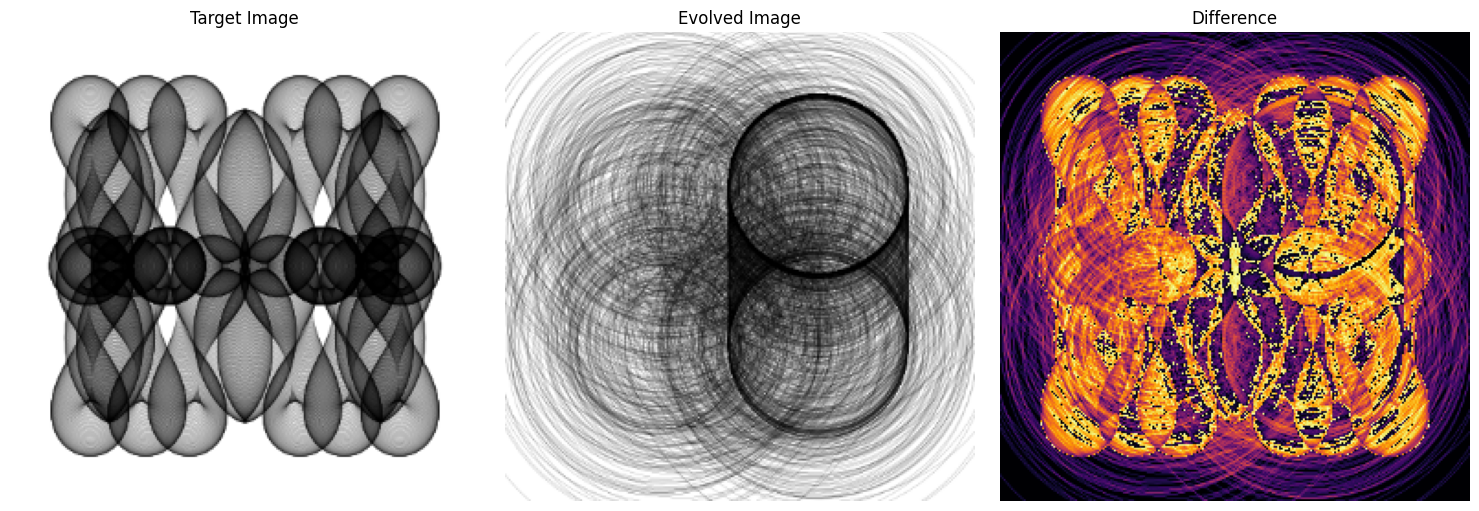

In [7]:
final_image = generate_image(k.flatten(), a, b, r)
final_processed = preprocess(final_image)
difference_image = np.abs(target_processed - final_processed)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(target_processed, cmap="gray")
axs[0].set_title("Target Image")
axs[0].axis('off')

axs[1].imshow(final_processed, cmap="gray")
axs[1].set_title("Evolved Image")
axs[1].axis('off')

axs[2].imshow(difference_image, cmap="inferno")
axs[2].set_title("Difference")
axs[2].axis('off')

plt.tight_layout()
plt.show()

In [8]:
print(est_a._program)

sin(sin(sin(sin(sin(sin(sin(sin(X0))))))))


In [9]:
print(est_b._program)

sin(sin(sin(sin(sin(sin(sin(sin(mul(X0, sin(sin(mul(X0, sin(mul(X0, sin(mul(X0, mul(X0, sin(sin(mul(X0, mul(X0, sin(sin(sin(sin(mul(X0, sin(mul(X0, sin(mul(X0, sin(sin(X0))))))))))))))))))))))))))))))))


In [10]:
print(est_r._program)

div(div(C18(-0.993), sin(div(C18(0.541), sin(div(sin(sub(X0, 0.531)), sin(sin(sub(X0, 0.531)))))))), div(div(div(C18(0.541), sin(sub(X0, div(div(C18(0.541), sin(div(C18(0.541), sub(X0, div(div(C18(sub(X0, sub(X0, add(C18(0.541), sin(sub(X0, 0.531)))))), sin(div(C18(0.541), sin(sub(X0, add(C18(0.541), sin(sin(sub(X0, add(C18(0.541), sin(sub(X0, 0.531)))))))))))), sin(sub(X0, 0.531))))))), sin(div(div(div(C18(0.541), sin(sub(X0, div(div(C18(C18(0.541)), sin(div(C18(0.541), sin(sub(X0, add(C18(0.541), sin(sin(sub(X0, add(C18(0.541), sin(sub(X0, 0.531)))))))))))), sin(sub(X0, 0.531)))))), sin(X0)), sin(add(X0, -0.749)))))))), sin(div(X0, 0.531))), sin(C18(0.541))))


In [11]:
dot_data = est_a._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph

In [12]:
dot_data = est_b._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph

In [13]:
dot_data = est_r._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph

In [14]:
est_a.run_details_.keys()

dict_keys(['generation', 'average_length', 'average_fitness', 'best_length', 'best_fitness', 'best_oob_fitness', 'generation_time'])

In [15]:
est_b.run_details_.keys()

dict_keys(['generation', 'average_length', 'average_fitness', 'best_length', 'best_fitness', 'best_oob_fitness', 'generation_time'])

In [16]:
est_r.run_details_.keys()

dict_keys(['generation', 'average_length', 'average_fitness', 'best_length', 'best_fitness', 'best_oob_fitness', 'generation_time'])